In [37]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)


In [48]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)
        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt


In [49]:
tickerSymbol = '^NSEI'
data = yf.Ticker(tickerSymbol)


In [50]:
prices = data.history(start='2022-03-06', end='2023-03-06').Close
returns = prices.pct_change().dropna()




Text(0, 0.5, 'Prices')

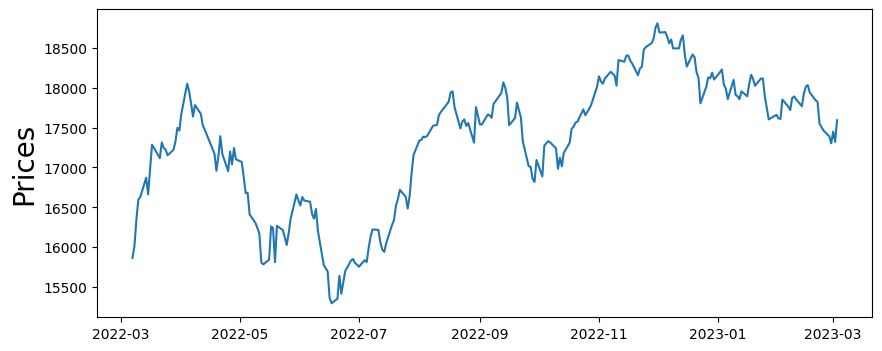

In [51]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

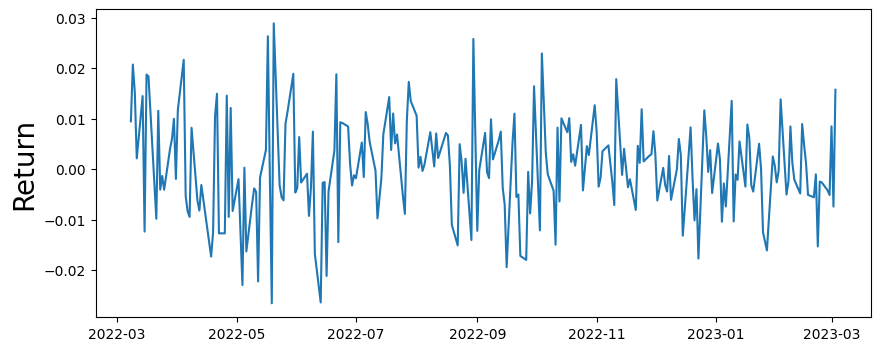

In [52]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

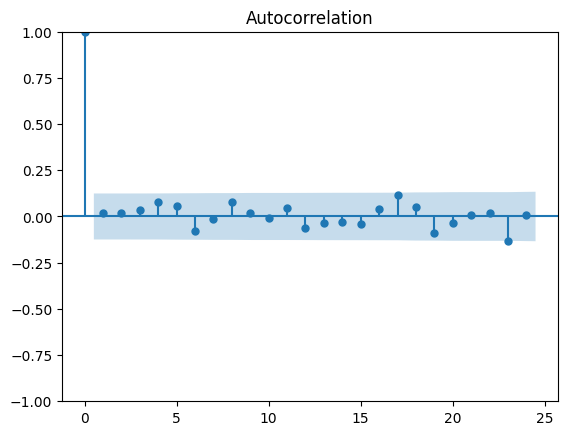

In [53]:
plot_acf(returns)
plt.show()

/home/khalid/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


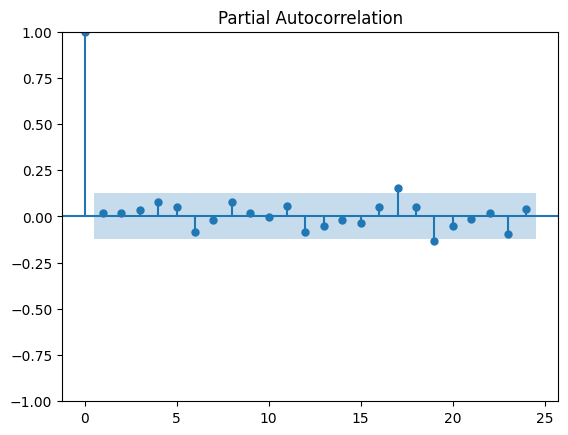

In [54]:
plot_pacf(returns)
plt.show()

# Baseline model


100%|███████████████████████████████████████| 234/234 [00:00<00:00, 2895.43it/s]


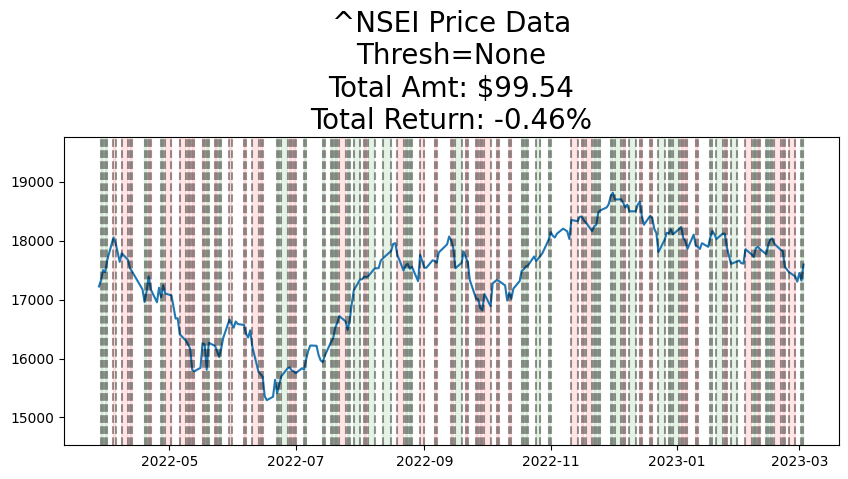

99.54312248591248

In [55]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

In [56]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]


100%|███████████████████████████████████████| 234/234 [00:00<00:00, 2138.32it/s]


100%|███████████████████████████████████████| 234/234 [00:00<00:00, 3454.19it/s]


100%|███████████████████████████████████████| 234/234 [00:00<00:00, 2759.05it/s]


100%|███████████████████████████████████████| 234/234 [00:00<00:00, 3504.40it/s]


100%|███████████████████████████████████████| 234/234 [00:00<00:00, 3277.92it/s]


100%|███████████████████████████████████████| 234/234 [00:00<00:00, 3087.81it/s]


100%|███████████████████████████████████████| 234/234 [00:00<00:00, 3462.11it/s]


100%|███████████████████████████████████████| 234/234 [00:00<00:00, 2978.22it/s]


100%|███████████████████████████████████████| 234/234 [00:00<00:00, 3469.07it/s]


100%|███████████████████████████████████████| 234/234 [00:00<00:00, 3161.52it/s]


/tmp/ipykernel_69538/2783033276.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_amts)


Text(0.5, 1.0, 'Avg: $101.08\nSD: $6.79')

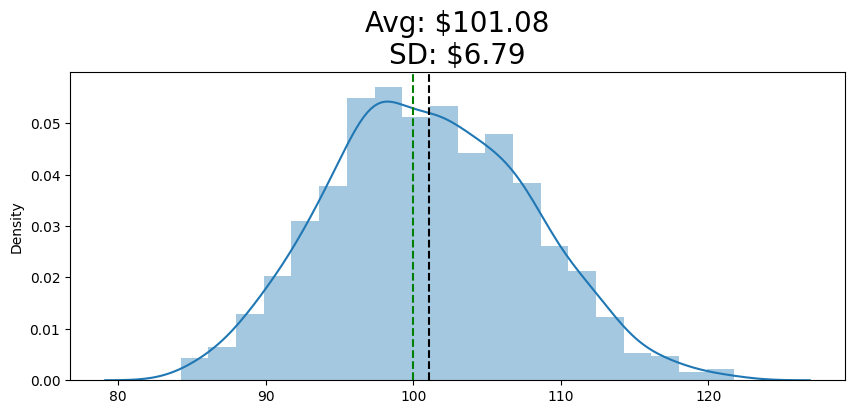

In [57]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

# If last return was positive, Buy

100%|███████████████████████████████████████| 234/234 [00:00<00:00, 2925.54it/s]


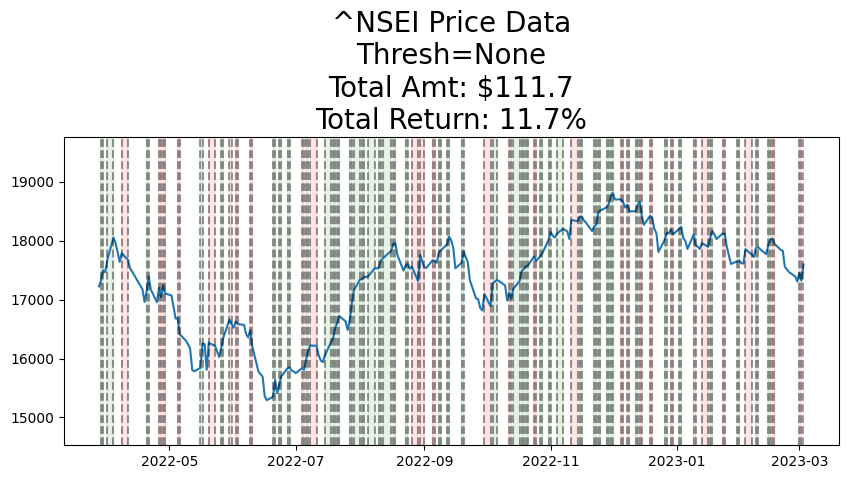

111.69999179868401

In [62]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)


# AR(1) MODEL

100%|███████████████████████████████████████| 234/234 [00:00<00:00, 2241.60it/s]


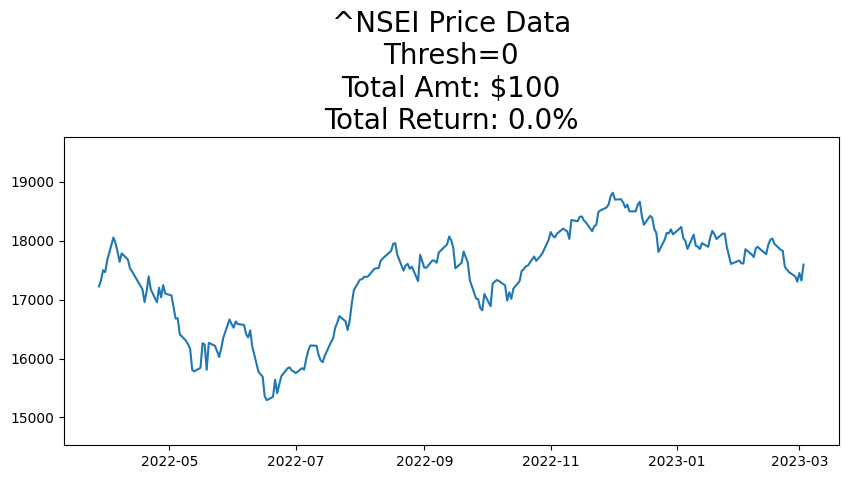

100%|███████████████████████████████████████| 234/234 [00:00<00:00, 3153.79it/s]


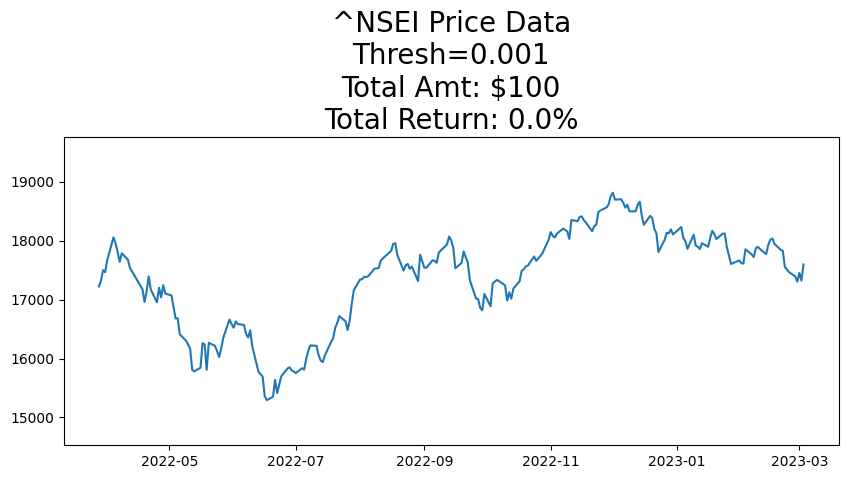

100%|███████████████████████████████████████| 234/234 [00:00<00:00, 2602.39it/s]


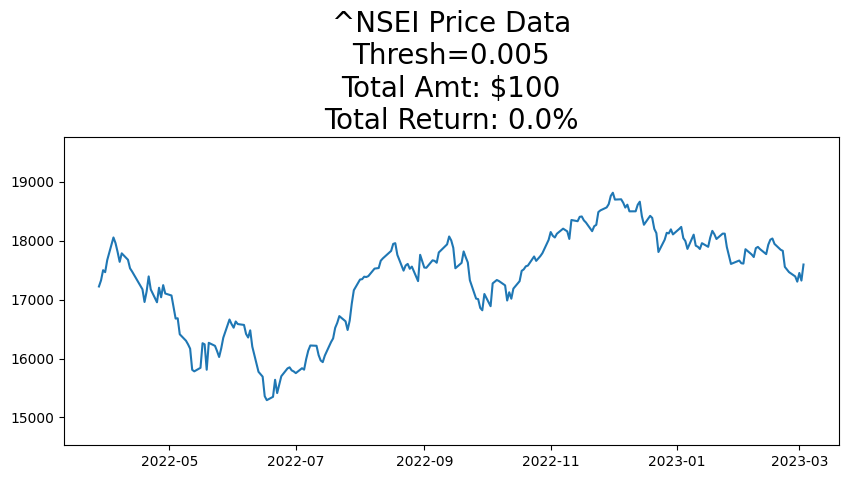

In [63]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

# AR(5) MODEL

100%|███████████████████████████████████████| 234/234 [00:00<00:00, 2780.23it/s]


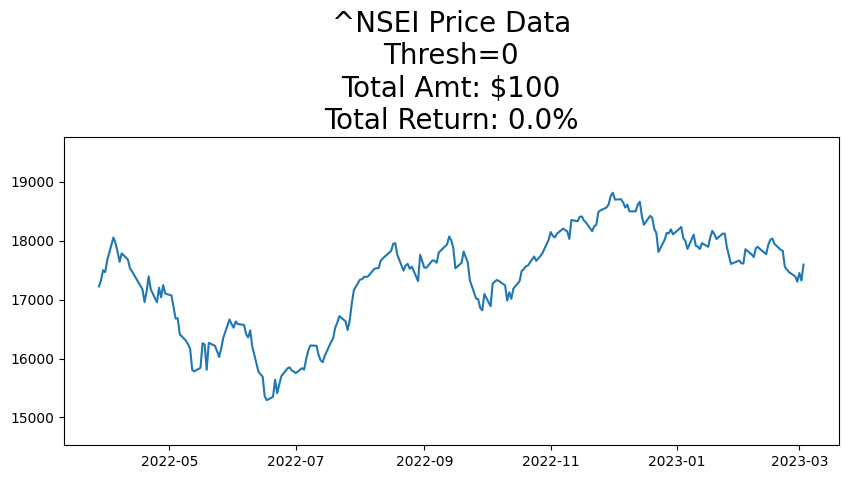

100%|███████████████████████████████████████| 234/234 [00:00<00:00, 2583.05it/s]


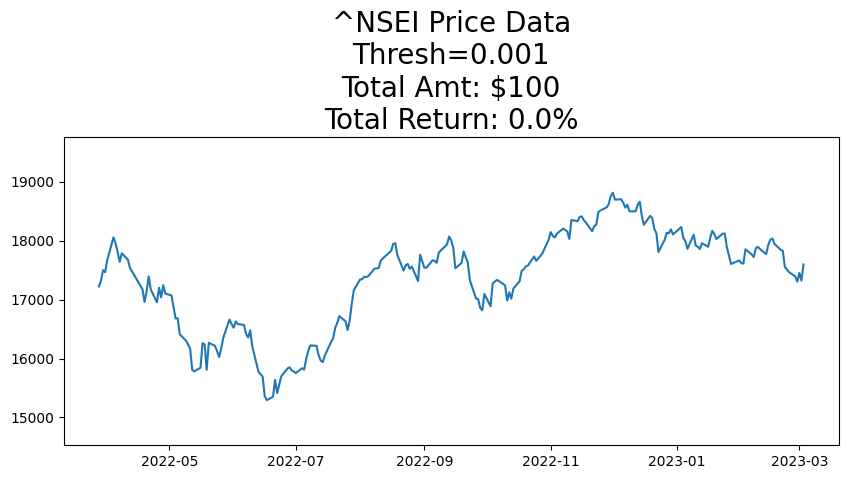

100%|███████████████████████████████████████| 234/234 [00:00<00:00, 2737.65it/s]


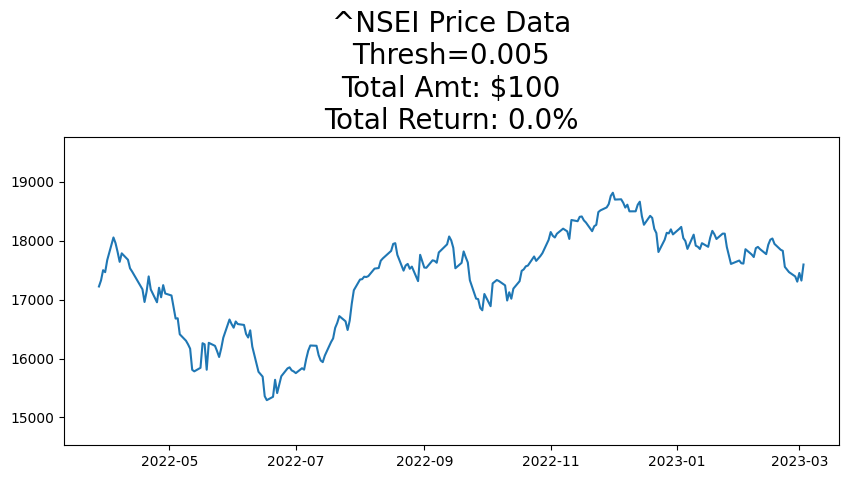

In [64]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,0), thresh, verbose=False)

# ARMA(5,5) MODEL

100%|███████████████████████████████████████| 234/234 [00:00<00:00, 2723.48it/s]


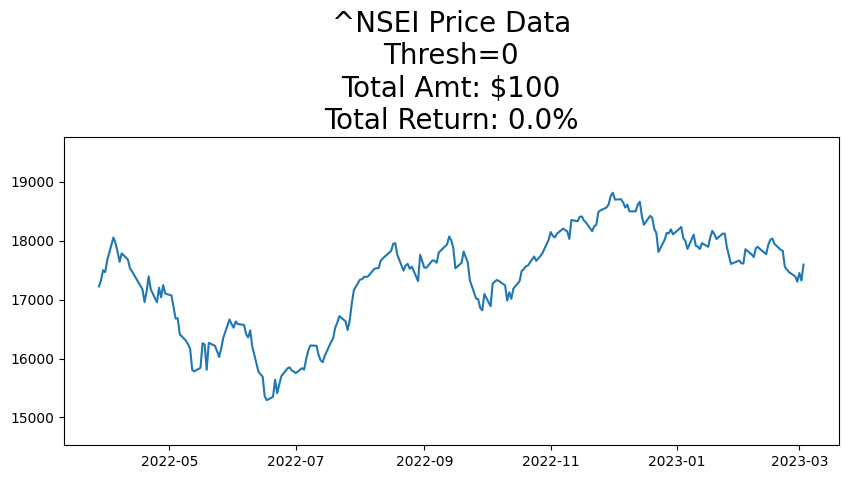

100%|███████████████████████████████████████| 234/234 [00:00<00:00, 3134.20it/s]


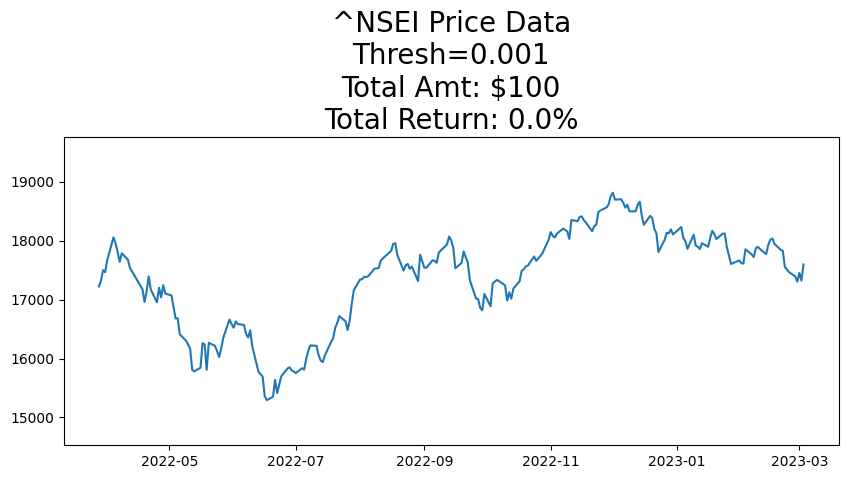

100%|███████████████████████████████████████| 234/234 [00:00<00:00, 2994.85it/s]


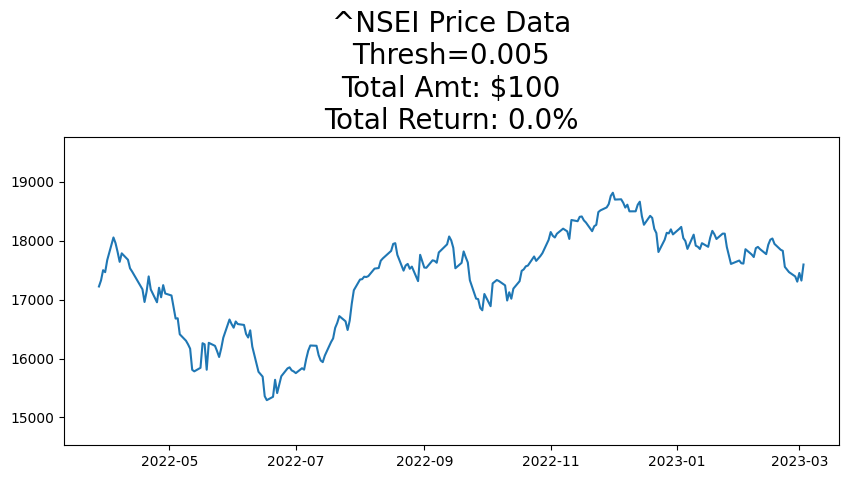

In [61]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,5), thresh, verbose=False)